In [1]:
# Importing numpy and all functions in implementations.py
import numpy as np
from implementations import *
import helpers as h
import matplotlib.pyplot as plt

In [2]:
# Loading the data and printing the shapes
Y, yHeader = h.loadData('./Data/y_train.csv')
X, xHeader = h.loadData('./Data/x_train.csv')
unIndexedX, unIndexedXHeader = X[:,1:], xHeader[1:]
unIndexedY, unIndexedYHeader = Y[:,1:], yHeader[1:]
print(f'y: {Y.shape}, x: {X.shape}\nunIndexedY: {unIndexedY.shape}, unIndexedX: {unIndexedX.shape}')

y: (328135, 2), x: (328135, 322)
unIndexedY: (328135, 1), unIndexedX: (328135, 321)


Out of 105331335 there are 58155556 valid entries, that is 0.5521201834193026 percent valid entries.


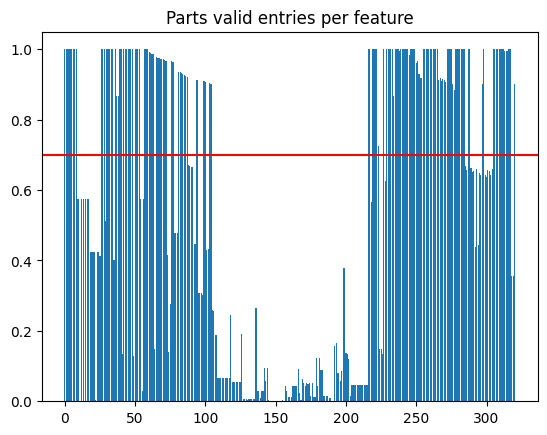

In [3]:
def inspectData(x):
    ''' Function for adding whatever inspection one would want, to help evaluate what datacleaning one may want to perform'''
    dataSize = x.size
    validEntries = x.count()

    validFeatureVals = x.count(axis=0)
    validFeatureParts = validFeatureVals/x.shape[0]

    print(f'''Out of {dataSize} there are {validEntries} valid entries, that is {validEntries/dataSize} percent valid entries.''')
    
    plt.bar(np.arange(0,validFeatureParts.shape[0]),validFeatureParts)
    plt.axhline(0.7, color='r')
    plt.title('Parts valid entries per feature')
    plt.show()

inspectData(unIndexedX)


As one can see, there are a lot of missing values, about 45% of the dataset are invalid entries. There are also a lot of features with a lot of missing values. We start by removing those features with less than 70% values present. To make sure each sample used may have some explanatory power, we remove the samples with more than 5 missing values in the remaining features. Then we check the resulting size of the dataset, and check how many invalid values are left, and how big a part of the remaining dataset they represent.

In [4]:
# Removing bad features
xFeaturesRemoved, xHeaderFeaturesRemoved = removeBadFeatures(unIndexedX,unIndexedXHeader,0.7)
# Removing bad samples
ySamplesRemoved, xSamplesRemoved = removeBadSamples(unIndexedY,xFeaturesRemoved,5)

print(f'The number of invalid entries remaing in the dataset is {xSamplesRemoved.size - xSamplesRemoved.count()}\nThat is {(xSamplesRemoved.size - xSamplesRemoved.count())/xSamplesRemoved.size} parts of the whole dataset')


For a threshold of 0.7, there are 144 good features, and 177 bad features
There remains in the data 289870 samples with at most 5 missing values
The number of invalid entries remaing in the dataset is 272938
That is 0.006538802834987332 parts of the whole dataset


In [5]:
"""
def standardizeData(x):
    ''' Function for normalizing the data'''
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0) # Subtract the mean and divide by the standard deviation
"""
xStandardized = standardizeData(xSamplesRemoved)

Removed 21050 samples with outliers more than 10 standard deviations from the mean. There remains 268820 samples in the dataset.


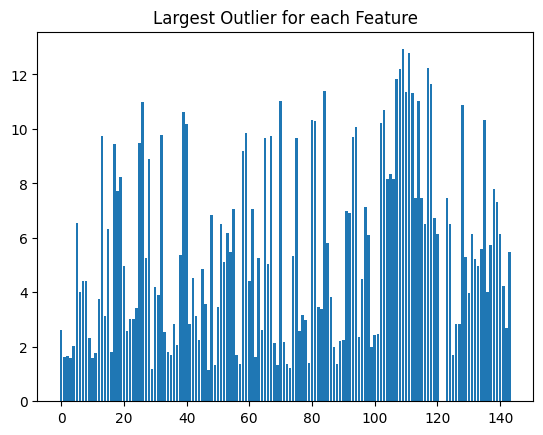

In [6]:

def detectOutliers(y, x, outlierThreshold=10):
    xStandardized = standardizeData(x)

    stdAwayFromMean = np.abs(xStandardized)

    # Assuming normal distribution, approx 68% of the data falls within 1 std, 95% within 2 std, 99.7% within 3 std
    # Therefore one may consider any entries in stdAwayFromMean > {outlierThreeshold=3} to be outliers - except that the data is not neccesarily normally distributed, so the threshold should be higher
    inlierRows = np.where(np.all(stdAwayFromMean < outlierThreshold, axis=1))[0]
    
    outlierRows = np.where(np.any(stdAwayFromMean > outlierThreshold, axis=1))[0]
    #print(outlierRows.shape)
    #print(inlierRows.shape)
    #print(x.shape)

    print(f'Removed {len(outlierRows)} samples with outliers more than {outlierThreshold} standard deviations from the mean. There remains {len(inlierRows)} samples in the dataset.')

    return y[inlierRows], x[inlierRows]

yOutliersRemoved, xOutliersRemoved = detectOutliers(ySamplesRemoved,xSamplesRemoved)

def largestOutliers(x):
    xStandardized = standardizeData(x)
    stdAwayFromMean = np.abs(xStandardized)
    largestOutliers = np.max(stdAwayFromMean,axis=0)
    largestOutliersFilled = np.ma.filled(largestOutliers,fill_value=0)
    plt.bar(np.arange(0,x.shape[1]),largestOutliersFilled)
    plt.title('Largest Outlier for each Feature')
    plt.show()
largestOutliers(xOutliersRemoved)


In [7]:
def balanceData(y,x):
    # Extracting the indices of the positive and negative cases, bundling them in a tuple, and bundling their lengths in tuples
    positiveCases = np.where(y == 1)[0]
    negativeCases = np.where(y == -1)[0]
    casesIndices = (positiveCases,negativeCases)
    casesLengths = (len(positiveCases),len(negativeCases))

    # Finding which subset is the smallest and largest (aka are there more negative or positive cases), and setting the smallestSubsetLength to the length of the smallest subset
    smallestSubset = np.argmin(casesLengths)
    largestSubset = np.argmax(casesLengths)
    smallestSubsetLength = casesLengths[smallestSubset]

    # Storing the cases from the smallest subset in an array
    balancedY = np.zeros(smallestSubsetLength*2)
    balancedX = np.zeros((smallestSubsetLength*2,x.shape[1]))
    balancedY[:smallestSubsetLength] = (y[casesIndices[smallestSubset]]).flatten()
    balancedX[:smallestSubsetLength] = x[casesIndices[smallestSubset]]

    # Randomly choosing as many samples from the largest subset as there are in the smallest subset, and storing them in the balanced array
    randomSampleIndices = np.random.permutation(casesLengths[largestSubset])[:smallestSubsetLength]
    balancedX[smallestSubsetLength:] = (x[casesIndices[largestSubset]])[randomSampleIndices]
    balancedY[smallestSubsetLength:] = ((y[casesIndices[largestSubset]])[randomSampleIndices]).flatten()

    # Shuffling the balanced arrays so no model can learn to classify the entries by their position in the dataset
    shufflingIndices = np.random.permutation(balancedY.shape[0])
    shuffledBalancedX = balancedX[shufflingIndices]
    shuffledBalancedY = balancedY[shufflingIndices]

    return shuffledBalancedY, shuffledBalancedX

balancedY, balancedX = balanceData(yOutliersRemoved,xOutliersRemoved)
print(balancedX.shape)

(46448, 144)


In [13]:
"""
def makeTrainingData(x):
    ''' Function filling the invalid values with the mean (zero), and adding a dummy variable'''
    xClean = np.ma.filled(x,fill_value=0) # Replace the invalid entries by zeros (aka the mean)
    tx = np.c_[np.ones(xClean.shape[0]),xClean] # Adding a dummy feature
    return np.nan_to_num(tx)
"""
tx = makeTrainingData(balancedX)

In [24]:
# w_logistic, loss_logistic = logistic_regression(balancedY,tx,np.zeros(tx.shape[1]),100,0.5)